In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold, GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_curve, roc_auc_score, auc
from xgboost import XGBClassifier

plt.style.use("Solarize_Light2")


import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv


In [3]:
data = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

# Data overview & Data preprocessing

In [4]:
data

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


In [5]:
data.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

+ No missing values    
  
Let's see how many unique values are in each attribute:

In [6]:
data.nunique()

Diabetes_binary          2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

+ Non-binary categorical features - `GenHlth`, `Education`, `Income`.

In [7]:
cat_col = ['GenHlth', 'Education', 'Income']

+ Continuous features - `BMI`, `MentHlth`, `PhysHlth`, `Age`

In [8]:
num = ['BMI', 'MentHlth', 'PhysHlth', 'Age']

+ Let's break all the values into separate variables

In [9]:
data = pd.get_dummies(data, columns=cat_col)

+ Divide the values of `BMI` (body mass index) into groups, update `BMI`

In [10]:
data['bmi_group'] = pd.cut(data['BMI'], (0, 16, 18.5, 25, 30, 35, 40, np.inf), labels=[1, 2, 3, 4, 5, 6, 7])

In [11]:
data.BMI = data['bmi_group']
data.drop('bmi_group', axis=1, inplace=True)

In [12]:
data.BMI = data.BMI.astype('float')

# Split and Scaler

There are 70692 values in the dataset, so we will divide the dataset into 2 parts: `train` and `test`.

In [13]:
X = data.drop(['Diabetes_binary'], axis=1)
y = data['Diabetes_binary']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

+ Let's scaled all numeric signs - `'BMI'`, `'MentHlth'`, `'PhysHlth'`, `'Age'`

In [15]:
num

['BMI', 'MentHlth', 'PhysHlth', 'Age']

In [16]:
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train[num])
x_test_sc = scaler.transform(x_test[num])

x_train[num] = x_train_sc
x_test[num] = x_test_sc

+ Let's define the functions

In [17]:
def xgb_class(clf, param_test, feat, target):
   
    kfold = StratifiedKFold(n_splits=3,
                            shuffle=True,
                            random_state=42)

    grid_search = GridSearchCV(clf,
                               param_test,
                               scoring="neg_log_loss",
                               n_jobs=-1,
                               cv=kfold)

    global grid_result
    grid_result = grid_search.fit(feat, target)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [18]:
def logistic_loss(clf, act, feat):
    return log_loss(act, clf.predict_proba(feat))

In [19]:
def quality_report(actual, prediction):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}\nRoc_auc: {:.3f}".format(
        accuracy_score(actual, prediction),
        precision_score(actual, prediction),
        recall_score(actual, prediction),
        f1_score(actual, prediction),
        roc_auc_score(actual, prediction)))

In [20]:
def plot_features(clf):
    feature_importances = clf.feature_importances_
    pd.DataFrame({'features': x_train.columns,
                                           'feature_importances': feature_importances})\
    .sort_values('feature_importances', ascending=False).plot.barh(x ='features', figsize=(10, 7))

# XGBClassifier

+ Let's run the model with default settings:

In [21]:
xgbc_start = XGBClassifier(random_state = 42, eval_metric='auc')

xgbc_start.fit(x_train, y_train)

predict_start = xgbc_start.predict(x_test)

print('\nTest quality: \n')
quality_report(y_test, predict_start)
print('\nLogistic Loss:')
logistic_loss(xgbc_start, y_test, x_test)


Test quality: 

Accuracy: 0.748
Precision: 0.727
Recall: 0.794
f1_score: 0.759
Roc_auc: 0.748

Logistic Loss:


0.516845130057971

Now let's fine-tune the `XGBClassifier`. To begin with, we determine the optimal learning rate and the number of trees. Let's take `net_log_loss` as a criterion. Although our data is balanced, but due to a logistical error, we will be able to better see the progress in finding parameters. And so it's easier to use any of the `confusion_matrix` metrics.

Best: -0.505493 using {'learning_rate': 0.01, 'n_estimators': 500}
-0.690242 (0.000006) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.687389 (0.000013) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.684593 (0.000022) with: {'learning_rate': 0.0001, 'n_estimators': 300}
-0.681851 (0.000029) with: {'learning_rate': 0.0001, 'n_estimators': 400}
-0.679166 (0.000040) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-0.666479 (0.000094) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.644382 (0.000182) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.625858 (0.000276) with: {'learning_rate': 0.001, 'n_estimators': 300}
-0.610213 (0.000405) with: {'learning_rate': 0.001, 'n_estimators': 400}
-0.596910 (0.000507) with: {'learning_rate': 0.001, 'n_estimators': 500}
-0.553718 (0.001321) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.520833 (0.002418) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.510402 (0.002725) with: {'learning_rate': 0.01, 'n_

Text(0, 0.5, 'Log Loss')

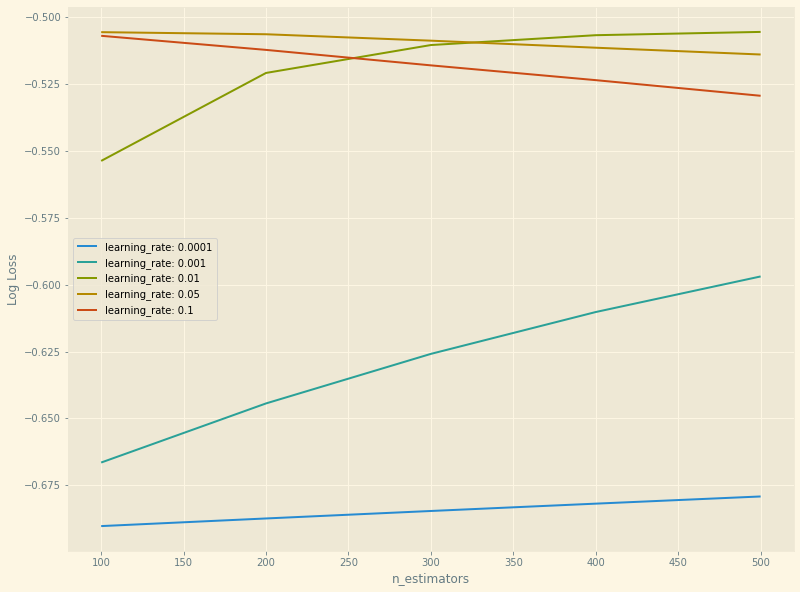

In [22]:
xgbc_clf = XGBClassifier(random_state = 42,
                         eval_metric='auc',
                         use_label_encoder=False) 


n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.05, 0.1]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

grid_search = GridSearchCV(xgbc_clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)

grid_result = grid_search.fit(x_train, y_train)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
plt.figure(figsize=(13,10))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

 let's run it again, but with boundary values `learning_rate`.

In [23]:
xgbc_clf = XGBClassifier(random_state = 42,
                         eval_metric='auc',
                         use_label_encoder=False)

low_e = int((grid_result.best_params_.get('learning_rate'))*100 - 5)
if low_e <= 0:
    low_e = int(1)
high_e = int((grid_result.best_params_.get('learning_rate'))*100 + 6)
if high_e >= 10:
    high_e = int(11)

param_test = {
'n_estimators':[100, 200, 300, 400, 500],
'learning_rate':[i/100.0 for i in range(low_e,high_e)]}


xgb_class(xgbc_clf, param_test, x_train, y_train)

Best: -0.504695 using {'learning_rate': 0.02, 'n_estimators': 300}
-0.553488 (0.000730) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.520325 (0.001089) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.509888 (0.001232) with: {'learning_rate': 0.01, 'n_estimators': 300}
-0.506313 (0.001218) with: {'learning_rate': 0.01, 'n_estimators': 400}
-0.505145 (0.001208) with: {'learning_rate': 0.01, 'n_estimators': 500}
-0.520151 (0.001081) with: {'learning_rate': 0.02, 'n_estimators': 100}
-0.506178 (0.001230) with: {'learning_rate': 0.02, 'n_estimators': 200}
-0.504695 (0.001083) with: {'learning_rate': 0.02, 'n_estimators': 300}
-0.505095 (0.001085) with: {'learning_rate': 0.02, 'n_estimators': 400}
-0.505844 (0.000947) with: {'learning_rate': 0.02, 'n_estimators': 500}
-0.509771 (0.001234) with: {'learning_rate': 0.03, 'n_estimators': 100}
-0.504699 (0.001047) with: {'learning_rate': 0.03, 'n_estimators': 200}
-0.505493 (0.000838) with: {'learning_rate': 0.03, 'n_estimators': 30

Let's add new parameters to the `params` dictionary, which we will use in the next training.

In [24]:
params = {}
params.update(grid_result.best_params_)
print("Add parameters: %s" % (grid_result.best_params_))

Add parameters: {'learning_rate': 0.02, 'n_estimators': 300}


Now let's set up `max_depth` and `min_child_weight`, set a spread of values and look for the best. 

In [25]:
xgbc_depth = XGBClassifier(random_state = 42,
                     eval_metric='auc',
                     use_label_encoder=False, **params) 

param_test = {
'max_depth':range(1,6,1),
'min_child_weight':range(1,6,1)}


xgb_class(xgbc_depth, param_test, x_train, y_train)

Best: -0.504350 using {'max_depth': 5, 'min_child_weight': 4}
-0.536968 (0.001313) with: {'max_depth': 1, 'min_child_weight': 1}
-0.536968 (0.001313) with: {'max_depth': 1, 'min_child_weight': 2}
-0.536968 (0.001313) with: {'max_depth': 1, 'min_child_weight': 3}
-0.536968 (0.001313) with: {'max_depth': 1, 'min_child_weight': 4}
-0.536968 (0.001313) with: {'max_depth': 1, 'min_child_weight': 5}
-0.514333 (0.001314) with: {'max_depth': 2, 'min_child_weight': 1}
-0.514333 (0.001314) with: {'max_depth': 2, 'min_child_weight': 2}
-0.514333 (0.001314) with: {'max_depth': 2, 'min_child_weight': 3}
-0.514333 (0.001314) with: {'max_depth': 2, 'min_child_weight': 4}
-0.514333 (0.001314) with: {'max_depth': 2, 'min_child_weight': 5}
-0.507754 (0.001369) with: {'max_depth': 3, 'min_child_weight': 1}
-0.507742 (0.001382) with: {'max_depth': 3, 'min_child_weight': 2}
-0.507740 (0.001359) with: {'max_depth': 3, 'min_child_weight': 3}
-0.507740 (0.001385) with: {'max_depth': 3, 'min_child_weight': 4}


In [26]:
params.update(grid_result.best_params_)
print("Add parameters: %s" % (grid_result.best_params_))

Add parameters: {'max_depth': 5, 'min_child_weight': 4}


Now let's configure `subsample` and `com sample_by three`, set a spread of values from 0.6 to 1.

In [27]:
xgbc_s_c = XGBClassifier(random_state = 42,
                         eval_metric='auc',
                         use_label_encoder=False, 
                        **params) 

param_test = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}


xgb_class(xgbc_s_c, param_test, x_train, y_train)

Best: -0.502942 using {'colsample_bytree': 0.9, 'subsample': 0.6}
-0.503172 (0.001161) with: {'colsample_bytree': 0.6, 'subsample': 0.6}
-0.503268 (0.001138) with: {'colsample_bytree': 0.6, 'subsample': 0.7}
-0.503225 (0.001269) with: {'colsample_bytree': 0.6, 'subsample': 0.8}
-0.503285 (0.001088) with: {'colsample_bytree': 0.6, 'subsample': 0.9}
-0.503414 (0.001154) with: {'colsample_bytree': 0.6, 'subsample': 1.0}
-0.503111 (0.001143) with: {'colsample_bytree': 0.7, 'subsample': 0.6}
-0.503136 (0.001284) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
-0.503191 (0.001128) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
-0.503281 (0.001145) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
-0.503445 (0.001197) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
-0.502962 (0.001153) with: {'colsample_bytree': 0.8, 'subsample': 0.6}
-0.503018 (0.001143) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
-0.503125 (0.001127) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
-0.503417 (

In [28]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.502942 using {'colsample_bytree': 0.9, 'subsample': 0.6}


let's run it again, but with boundary values.

In [29]:
xgbc_s_c = XGBClassifier(random_state = 42,
                         eval_metric='auc',
                         use_label_encoder=False, 
                        **params)

low_s = int((grid_result.best_params_.get('subsample'))*100 - 5)
if low_s <= 0:
    low_s = int(1)
high_s = int((grid_result.best_params_.get('subsample'))*100 + 6)
if high_s >= 100:
    high_s = int(101)


low_c = int((grid_result.best_params_.get('colsample_bytree'))*100 - 5)
if low_c <= 0:
    low_c = int(1)
high_c = int((grid_result.best_params_.get('colsample_bytree'))*100 + 6)
if high_c >= 100:
    high_c = int(101)

param_test = {
 'subsample':[i/100.0 for i in range(low_s,high_s)],
 'colsample_bytree':[i/100.0 for i in range(low_c, high_c)]
}


xgb_class(xgbc_s_c, param_test, x_train, y_train)

Best: -0.502942 using {'colsample_bytree': 0.9, 'subsample': 0.6}
-0.503111 (0.001099) with: {'colsample_bytree': 0.85, 'subsample': 0.55}
-0.503102 (0.001041) with: {'colsample_bytree': 0.85, 'subsample': 0.56}
-0.503036 (0.001052) with: {'colsample_bytree': 0.85, 'subsample': 0.57}
-0.503083 (0.001212) with: {'colsample_bytree': 0.85, 'subsample': 0.58}
-0.503078 (0.001261) with: {'colsample_bytree': 0.85, 'subsample': 0.59}
-0.503091 (0.001156) with: {'colsample_bytree': 0.85, 'subsample': 0.6}
-0.503082 (0.001209) with: {'colsample_bytree': 0.85, 'subsample': 0.61}
-0.503055 (0.001196) with: {'colsample_bytree': 0.85, 'subsample': 0.62}
-0.503101 (0.001136) with: {'colsample_bytree': 0.85, 'subsample': 0.63}
-0.503255 (0.001241) with: {'colsample_bytree': 0.85, 'subsample': 0.64}
-0.503221 (0.001094) with: {'colsample_bytree': 0.85, 'subsample': 0.65}
-0.503111 (0.001099) with: {'colsample_bytree': 0.86, 'subsample': 0.55}
-0.503102 (0.001041) with: {'colsample_bytree': 0.86, 'subs

Let's add new parameters to the `params` dictionary, which we will use in the next training.

In [30]:

params.update(grid_result.best_params_)
print("Add parameters: %s" % (grid_result.best_params_))

Add parameters: {'colsample_bytree': 0.9, 'subsample': 0.6}


Configure the `gamma` parameter, set values from 0 to 1

In [31]:
xgbc_g = XGBClassifier(random_state = 42,
                         eval_metric='auc',
                         use_label_encoder=False, 
                        **params) 

param_test = {
 'gamma':[i/10.0 for i in range(0,11)]
}


xgb_class(xgbc_g, param_test, x_train, y_train)

Best: -0.502942 using {'gamma': 0.0}
-0.502942 (0.001227) with: {'gamma': 0.0}
-0.503049 (0.001257) with: {'gamma': 0.1}
-0.503046 (0.001256) with: {'gamma': 0.2}
-0.503042 (0.001224) with: {'gamma': 0.3}
-0.503046 (0.001196) with: {'gamma': 0.4}
-0.503040 (0.001197) with: {'gamma': 0.5}
-0.503005 (0.001225) with: {'gamma': 0.6}
-0.503027 (0.001206) with: {'gamma': 0.7}
-0.503010 (0.001271) with: {'gamma': 0.8}
-0.503036 (0.001251) with: {'gamma': 0.9}
-0.502987 (0.001217) with: {'gamma': 1.0}


In [32]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.502942 using {'gamma': 0.0}


Let's run it again, but with boundary values.

In [33]:
xgbc_g = XGBClassifier(random_state = 42,
                         eval_metric='auc',
                         use_label_encoder=False, 
                        **params) 

low_g = int((grid_result.best_params_.get('gamma'))*100 - 5)
if low_g <= 0:
    low_g = int(1)
high_g = int((grid_result.best_params_.get('gamma'))*100 + 6)
if high_g >= 100:
    high_g = int(101)

param_test = {
 'gamma':[i/100.0 for i in range(low_g,high_g)]
}


xgb_class(xgbc_g, param_test, x_train, y_train)

Best: -0.502970 using {'gamma': 0.01}
-0.502970 (0.001227) with: {'gamma': 0.01}
-0.502970 (0.001227) with: {'gamma': 0.02}
-0.502985 (0.001218) with: {'gamma': 0.03}
-0.503003 (0.001209) with: {'gamma': 0.04}
-0.502983 (0.001195) with: {'gamma': 0.05}


In [34]:
params.update(grid_result.best_params_)
print("Add parameters: %s" % (grid_result.best_params_))

Add parameters: {'gamma': 0.01}


Let's run the final model with the values obtained in the sample `test` 

In [35]:
xgbc_fin = XGBClassifier(random_state = 42,
                         eval_metric='auc',
                         use_label_encoder=False, 
                        **params)


xgbc_fin.fit(x_train, y_train)

predict_xgbc = xgbc_fin.predict(x_test)

print('\nTest quality: \n')
quality_report(y_test, predict_xgbc)


Test quality: 

Accuracy: 0.753
Precision: 0.730
Recall: 0.803
f1_score: 0.765
Roc_auc: 0.753


In [36]:
print('The first result: %s' % logistic_loss(xgbc_start, y_test, x_test))
print('Result with parameter tuning: %s' % logistic_loss(xgbc_fin, y_test, x_test))

The first result: 0.516845130057971
Result with parameter tuning: 0.5031887641962111


Let's see which variabilities  had the greatest impact on learning.

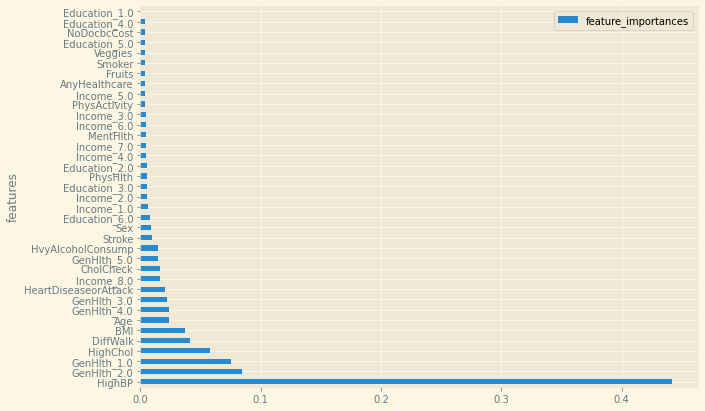

In [37]:
plot_features(xgbc_fin)

Let's see how the probabilities of classes 1 and 0 were distributed in the predicted model

In [38]:
pred_proba = xgbc_fin.predict_proba(x_test)

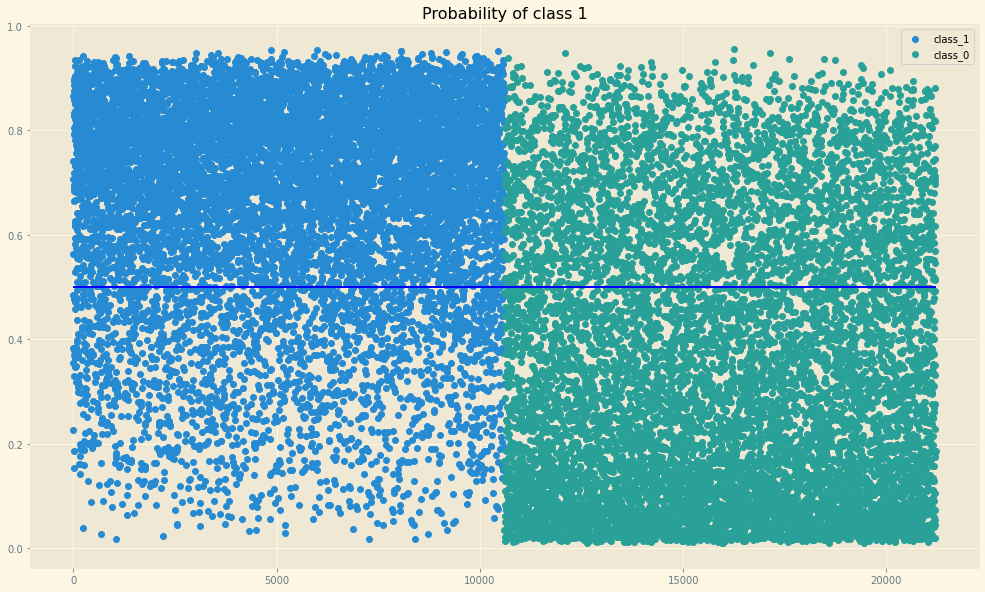

In [39]:
class_1 = pred_proba[:, 1][y_test == 1]
class_0 = pred_proba[:, 1][y_test == 0]
threshold = 0.5
plt.figure(figsize=(17,10))
plt.scatter(np.arange(len(class_1)), class_1, label='class_1')
plt.scatter(np.arange(len(class_1), len(class_1)+len(class_0)), class_0, label='class_0')
plt.plot([-0.2, len(pred_proba[:, 1])], [threshold, threshold], c='b')
plt.title('Probability of class 1')
plt.legend();

The blue labels are class 1, the green labels are class 0 in `y_test`, the blue line is a threshold of 0.5, which are separated by class 1 and 0 in the predicted model. Green labels above the blue line and blue labels below the blue line are incorrectly classified classes.

Let's change the threshold 0.5  to see how the values of `precision`, `recall`, `F1` and `accuracy` will change.

In [40]:
msg_row = pd.DataFrame(columns=['threshold', 'precision', 'recall',
               'F1', 'accuracy'])
threshold = 0.3
data_threshold = pd.DataFrame()
for i in range(300):
    threshold += 0.001
    pred = np.where(pred_proba[:, 1] >= threshold, 1, 0)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    new_row = {'threshold': threshold, 'precision':precision, 'recall':recall,
               'F1':f1, 'accuracy':accuracy, 'SUM': precision+recall+f1+accuracy}
    msg_row = msg_row.append(new_row, ignore_index=True)

In [41]:
msg_row.head()

,threshold,precision,recall,F1,accuracy,SUM
0,0.301,0.657538,0.928329,0.769814,0.722416,3.078097
1,0.302,0.657865,0.928046,0.769941,0.722699,3.078551
2,0.303,0.658367,0.927575,0.770122,0.723123,3.079187
3,0.304,0.658607,0.927292,0.770189,0.723312,3.079399
4,0.305,0.659045,0.926914,0.770358,0.723689,3.080007


<AxesSubplot:xlabel='threshold'>

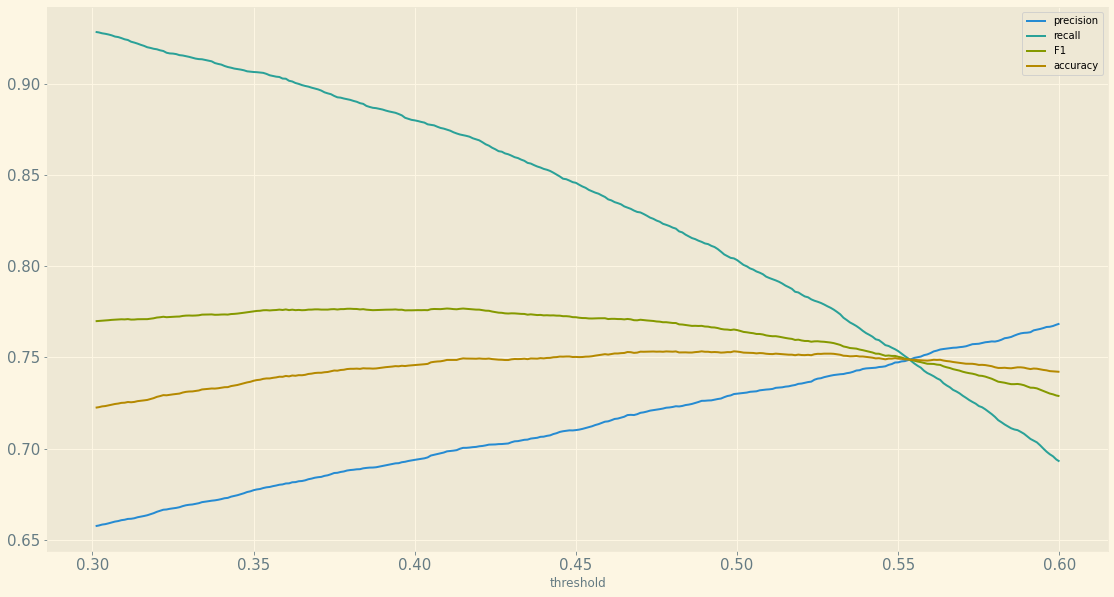

In [42]:
msg_row.plot(x='threshold', y=['precision', 'recall',
               'F1', 'accuracy'], figsize=(19, 10), fontsize=15)

When the threshold is increased, the `recall` drops sharply and the `precision` increases. At the threshold value of 0.54, the metrics intersect and have an equal value of 0.751.